
<div>
<img src="images/HW3_q1_1.png" width="1500"/>
</div>

<div>
<img src="images/HW3_q1_2.png" width="1500"/>
</div>


<div>
<img src="images/HW3_q2.png" width="1500"/>
</div>

In [5]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

import math as math
from collections import Counter
from numpy import genfromtxt

In [2]:
df_X_train = genfromtxt('./data/gaussian_process/X_train.csv', delimiter=',')
df_Y_train = genfromtxt('./data/gaussian_process/y_train.csv', delimiter=',')
df_X_test = genfromtxt('./data/gaussian_process/X_test.csv', delimiter=',')
df_Y_test = genfromtxt('./data/gaussian_process/y_test.csv', delimiter=',')

In [3]:
def Gaussian_Kernel ( xi , xj , b):
    sq_dist = 0.0
    if ("array" not in str(type(xi)) ):
#        print xi , str(type(xi))
        xi = np.array([xi])
        xj = np.array([xj])
#        print "new", xi
#    print xi , xj 
        
    for i , j  in zip(xi,xj): 
        d = (i - j)**2 
        sq_dist = sq_dist + d
    GK = np.exp((-1.0/b)*sq_dist)
    return GK

def getKn ( X ,b , K_mat):
    i = 0     
    for Xi in X:
        j = 0 
        for Xj in X:
            #print type(Xi)
            K_mat[i, j] =  Gaussian_Kernel(Xi , Xj , b)
            j = j+ 1 
        i = i + 1    
    return K_mat 

def getK_Dn ( X_test , X_train , b, K_Dn_mat):
    i = 0 
    for xi in X_test:
        j = 0 
        for xj in X_train:
            K_Dn_mat[i,j] = Gaussian_Kernel(xi , xj , b)
            j = j + 1
        i = i + 1        
    return K_Dn_mat

def sigma_Identity (sigma_sq , I ):
    return sigma_sq * np.identity(I)
    
def predict ( KDN ,SIGMA_SQ_I , KN , Y ):
    return np.dot(np.dot(KDN, inv(SIGMA_SQ_I + KN)), Y)
    
    
def getRMSE (Y_predict ,Y_test ):

     square_error  =  np.square(Y_predict - Y_test)
     RMSE =  np.sqrt((np.sum(square_error)/len(Y_test)))
 
     return RMSE

Text(0,0.5,'Y - Predict')

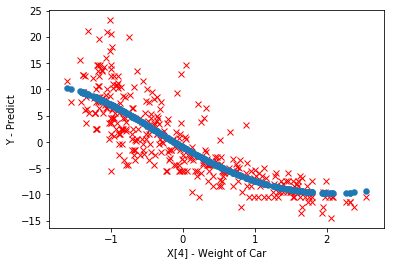

In [4]:
b = 5 
var = 2
       
Kn_matrix = np.zeros((350,350))   
Kn =  getKn(df_X_train[:,3] , b , Kn_matrix) 
K_Dn_matrix= np.zeros((350,350))
K_Dn =  getK_Dn(df_X_train[:,3] , df_X_train[:,3] , b, K_Dn_matrix) 
sigma_sq_I =  sigma_Identity( var , 350)
Y_predict =  predict(K_Dn,sigma_sq_I,Kn,df_Y_train)                    
        
plt.figure(1)
plt.scatter( df_X_train[:,3] , df_Y_train , marker='x', color='r'  , linewidth=1  ) 

plt.scatter(df_X_train[:,3] , Y_predict , linewidth=0.4  ) 

plt.xlabel("X[4] - Weight of Car")
plt.ylabel("Y - Predict")

In [6]:
df_X_train = genfromtxt('./data/boosting/X_train.csv', delimiter=',')
df_Y_train = genfromtxt('./data/boosting/y_train.csv', delimiter=',')
df_X_test = genfromtxt('./data/boosting/X_test.csv', delimiter=',')
df_Y_test = genfromtxt('./data/boosting/y_test.csv', delimiter=',')

df_X_train_new = np.insert(df_X_train, 0, 1, axis=1)
df_X_test_new = np.insert(df_X_test, 0, 1, axis=1)

In [13]:
def Least_sq_classifier(X_train , Y_train):
    part1 = np.dot(inv(np.dot(X_train.T, X_train)), X_train.T)
    W = np.dot(part1 , Y_train)
    return W
    

def predict (W , X_test):
  Y_pred = []
  for x in X_test:
   # print x , W
   # print  (np.dot(x, W))
    if (np.dot(x.T, W) <= 0.0):
        Y_pred.append(-1.0)
    if (np.dot(x.T, W) > 0.0):
        Y_pred.append(1.0)
  return Y_pred

  
    

def getBootstrapData(x, y, weights):
    sample = [np.random.choice(range(len(x)), p=weights) for i in range(len(x))]
    x_s = []
    y_s = []
    for i in sample:
        x_s.append(x[i])
        y_s.append(y[i])
    return np.asanyarray(x_s), np.asanyarray(y_s)



def getError(y, y_pred, w_t):

    miss_class = np.matrix(abs(np.asarray(y) - np.asarray(y_pred))/2)
    e = miss_class * np.matrix(w_t).T
    e = e[0,0]

    return e

def getUpdatedWeights (a, y, y_pred, w_t):
    w_hat = [w_t[i]*math.exp(-1.0 *a*y[i]*y_pred[i]) for i in range(len(y))]
    w_hat_total = np.sum(w_hat)
    weights = w_hat/w_hat_total
    return weights

def getMError(y, y_pred):


    miss_class = np.matrix(abs(y - y_pred)/2)
    return np.sum(miss_class)/float(len(y))
    


def AdaBoost (T , X_train, Y_train, X_test, Y_test):
     # Bootstapping sample
    weights = [1.0/len(X_train) for row in range(X_train.shape[0])]
    weights =  np.asarray(weights)   
#    print weights
    #w = "null"
    
    error_boost = []
    Alpha_boost = []
    X_train_Sample_boost = []
    weights_boost = []
    training_error = []
    test_error = []    
    
    f_boost_training = np.zeros(len(X_train))
    f_boost_test =np.zeros(len(X_test))    
    e_upperbd = []
    e_upperbd.append(1)
    c =0
    
    
    e = 0.0
    for t in range(T):

        #print ("** boosting iteration **: ", t)
        x_s , y_s =  getBootstrapData ( X_train , Y_train, weights)       
        
        classifier = Least_sq_classifier(x_s , y_s)
#        print "point 1"
        Y_pred = predict(classifier , x_s)
        

        
        e = getError(Y_train, Y_pred, weights)

        if e>.5 :
            Y_pred = predict((-1.0 * classifier) , x_s)

            e = getError(Y_train, Y_pred, weights)

        
        alpha = float(0.5 * math.log((1.0 -e)/e) )
#        print "alpha : " , alpha     
#        print "error:" , e
        
        
        val = np.dot(X_test , classifier)
        y_pred_test =  np.sign(val)

        
        f_boost_training += (np.array(Y_pred))*alpha
        f_boost_test += (np.array(y_pred_test))*alpha


    #  training and test predictions for F_boost
        f_boost_pred_train = np.sign(f_boost_training)
        f_boost_pred_test = np.sign(f_boost_test)

    #get f_boost training and test error

        training_error.append(getMError(Y_train,f_boost_pred_train))
        test_error.append(getMError(Y_test,f_boost_pred_test))
        
        
        error_boost.append(e)
        X_train_Sample_boost.append(x_s)
        Alpha_boost.append(alpha)
        weights_boost.append(weights)
        
        w = getUpdatedWeights(alpha, Y_train, Y_pred, weights)
        weights = w
        
        bd = math.exp(-2*((.5-e)**2))
        e_upperbd.append(e_upperbd[c]*bd)
        c+=1
    return training_error, test_error , error_boost , Alpha_boost , e_upperbd ,X_train_Sample_boost

In [14]:
        
training_error , test_error , error_boost, Alpha_boost, e_upperbd ,X_train_Sample_boost= AdaBoost(1500, df_X_train_new , df_Y_train , df_X_test_new , df_Y_test)

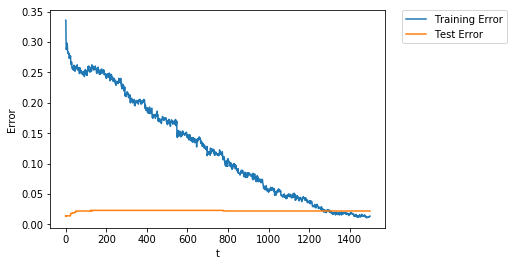

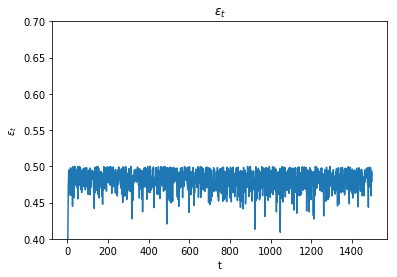

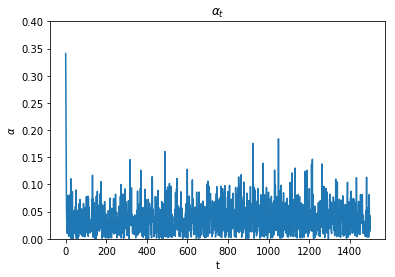

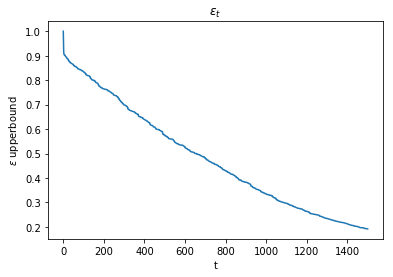

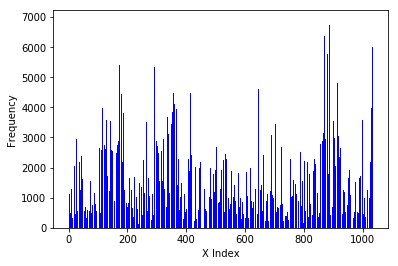

In [15]:

plt.figure(2)
plt.plot(training_error, label = "Training Error")
plt.plot(test_error, label = "Test Error" )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("t")
plt.ylabel("Error")
plt.show()

plt.figure(3)
plt.plot(error_boost)
plt.xlabel("t")
plt.ylabel("$\epsilon_{t}$")
plt.ylim(.4,.7)
plt.title("$\epsilon_{t}$")
plt.show()

plt.figure(4)
plt.plot(Alpha_boost)
plt.xlabel("t")
plt.ylabel("$\\alpha$")
plt.ylim(0,.4)
plt.title("$\\alpha_{t}$")
plt.show()

plt.figure(5)
plt.plot(e_upperbd)
plt.xlabel("t")
plt.ylabel("$\epsilon$ upperbound")
plt.title("$\epsilon_{t}$")
plt.show()

### histogram
bx = np.matrix(df_X_train_new)
x_count = []
for i in X_train_Sample_boost:
    for j in i:
        j = np.where(np.all(bx==np.matrix(j),axis=1))
        x_count.append(j[0][0])

x  = range(1036)
y = Counter(x_count)

counts = np.zeros(len(df_X_train_new))
for i in range(len(df_X_train_new)):
    counts[i] += y[i]
plt.figure(6)
plt.bar(x, counts, color = 'blue')
plt.xlabel("X Index")
plt.ylabel("Frequency")


plt.show()
